### **Convolutional Neural Networks, and Large Scale Visual Recognition Project**
<em>University of Virginia - Introduction to Computer Vision - Fall 2019 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this assignment we will apply our knowledge of machine learning and visual recognition using convolutional neural networks to detect various kinds of things from images. 



#### **1. Pytorch on the GPU**
As we deal with increasingly complex models, and larger datasets and image resolutions, we need to be efficient in computing matrix multiplications. In this section we will experiment with GPU computations and how they speed up some computations under certain conditions. Now we are going to test the GPU environment in a task of multiplying two square matrices of size $d\times d$. We provide code below sample code and output for this part but you need to complete the test below.

In [1]:
import torch
import time

# Let's create two matrices of size 4x4 and full of ones.
d = 4000
a = torch.rand(d, d)
b = torch.rand(d, d)

# Compute a dot product between the two matrices in CPU.
start_time = time.time()
output = torch.mm(a,b)  # Regular multiplication in CPU.
cpu_time = time.time() - start_time
print('CPU-time {0:.6f}s'.format(cpu_time))

# Compute a dot product between the two matrices in GPU.
start_time = time.time()
a = a.cuda() # Move to GPU.
b = b.cuda() # Move to GPU.
output = torch.mm(a,b)  # Multiplication happens in GPU.
gpu_time = time.time() - start_time
print('GPU-time {0:.6f}s\n'.format(gpu_time))

print('CPU was {0:.2f}x times the GPU time'.format(cpu_time / gpu_time))

CPU-time 0.986532s
GPU-time 5.220509s

CPU was 0.19x times the GPU time


**Final Comments:** In the GPU code there is a more or less fixed cost of moving tensors to the GPU, this causes using GPUs slower for small tensors counter-productive. Try timing this separately and estimate the cost of this move. Most functions in pytorch have a CUDA implementation so just by moving tensors to the GPU using .cuda() you can perform any operation in a highly parallel manner on a GPU. Moreover, Pytorch supports parallelization on multiple GPUs as well.<br/><br/>

#### **2. Convolutional Neural Networks**
This section will build on the previous project but now we will use a convolutional neural network to obtain higher accuracies.

##### **2.1 CIFAR-10 Data Loading**
In this section we will load the CIFAR-10 dataset, a dataset with 50 thousand training images of size 3x32x32 each belonging to one out of 10 possible categories of objects. First, let's download a local copy from the CS server.

0it [00:00, ?it/s]

170500096it [00:04, 41513237.26it/s]                               


Extracting ./datalab/cifar-10-python.tar.gz to ./datalab


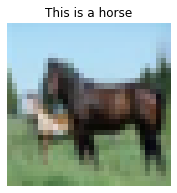

In [0]:
import matplotlib.pyplot as plt
from torchvision import datasets

# This is a convenient data reader.
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
train_data = datasets.CIFAR10('./datalab', train = True, download = True)

# This samples the 12-th image from the dataset.
# Try changing the index below to see different images in the dataset.
image, category = train_data[12]

# Display the image and its label.
plt.figure(figsize=(3,3))
plt.title('This is a %s' % categories[category])
plt.imshow(image); plt.grid('off');plt.axis('off')
plt.show()

##### **2.2 Convolutional Neural Network classifier**
In this section, you will define a convolutional neural network classifier and compute the accuracy of the model on CIFAR-10. Feel free to create any network that you consider would work well. You can get inspiration in some of the convolutional neural network architectures studied in class. I recommend you start with the LeNet architecture included below and start from there.

In [0]:
# Defining the model.
from tqdm import tqdm as tqdm
import torch.nn as nn
import torch.optim as optim

# LeNet is French for The Network, and is taken from Yann Lecun's 1998 paper
# on digit classification http://yann.lecun.com/exdb/lenet/
# This was also a network with just two convolutional layers.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Conv1 + ReLU + MaxPooling.
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        # Conv2 + ReLU + MaPooling.
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        # Linear layer + ReLU.
        out = F.relu(self.fc1(out))
        # Another linear layer + ReLU.
        out = F.relu(self.fc2(out))
        # A final linear layer at the end.
        out = self.fc3(out)
       
        # We will not add nn.LogSoftmax here because nn.CrossEntropy has it.
        # Read the documentation for nn.CrossEntropy.
        return out
        
        
# Definition of our network.
classifier = LeNet()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
# This optimizer has access to all the parameters in the model.
#
# It can zero all the parameters by doing:
#                                  optimizer.zero_grad()
#
# It can perform an SGD optimization update step in the direction of
# the gradients for each parameters by doing:
#                                  optimizer.step()
#
learningRate = 0.05
optimizer = optim.SGD(classifier.parameters(), lr = learningRate)

#### **3. Deep Convolutional Neural Networks**
In this section we will use a state-of-the-art deep neural network trained on the ILSVRC (Imagenet Large Scale Visual Recognition Challenge) dataset.




In this section we will experiment with a ResNet network with 50 layers of depth as seen during class. This network was trained in the ILSVRC task where it was trained on a million images each with one label belonging to 1000 possible classes. First let's load the pre-trained model that comes with Pytorch and categories vocabulary.

In [4]:
import torchvision.models as models

# Download list of 1000 categories for the ILSVRC task in right order.
!wget -nc http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
  
# Load the pre-trained model from the torchvision package.
resnet = models.resnet50(pretrained = True);
resnet.eval();  # Set in evaluation mode! In this case it matters.

--2019-11-19 16:06:05--  http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K)
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.09s   

2019-11-19 16:06:06 (382 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


Now let's run an image through the network. Pay careful attention to all the steps.

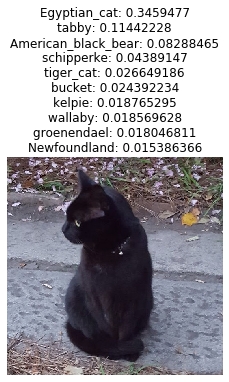

In [5]:
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import json, io, requests, string
import torch.nn.functional as F
import torch

# 1. Define the appropriate image pre-processing function.
# This depends on the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}


# 3. Read image from URL into a PIL image type.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
inputVar =  preprocessFn(img_pil).unsqueeze(0)
predictions = resnet(inputVar)

# 5. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid('off'); plt.axis('off');

### **Assignment Questions** (10pts)


#### **1. GPU Benchmarking** (1pts)
From the example code given in section 1, produce a plot using matplotlib that shows the execution time (y-axis) versus the size $d$ of the square matrices (x-axis) for both GPU and CPU (use values of $d$ = [10, 100, 1000, 5000, 10000]). Answer the following question: For what values of $d$ would you recommend using a GPU?

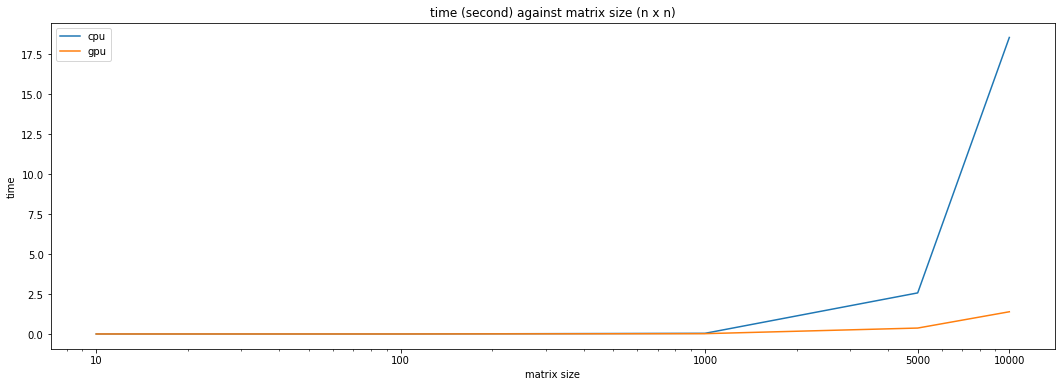

In [0]:
# Your code goes here.
import torch
import time 
import numpy as np
time_cpu = []
time_gpu = []
d = [10, 100, 1000, 5000, 10000]

def mm_time(n, gpu=False): 
  start_time = time.time()
  a, b = torch.rand(n, n), torch.rand(n, n)
  if gpu: 
    a, b = a.cuda(), b.cuda()
  torch.mm(a, b)
  return float("{0:.2f}".format((time.time() - start_time)))

for t in d: 
  time_cpu.append(mm_time(t))
  time_gpu.append(mm_time(t, True))
fig, ax1 = plt.subplots(1, 1, figsize=(18, 6))
r = [10, 100, 1000, 5000, 10000]
ax1.set_title('time (second) against matrix size (n x n)')
ax1.set_xlabel('matrix size')
ax1.set_ylabel('time')
ax1.set_xscale('log', basex=10)
ax1.set_xticks(r)
ax1.set_xticklabels(d)
ax1.plot(d, time_cpu, label = 'cpu')
ax1.plot(d, time_gpu, label = 'gpu')
ax1.legend()

#### **2. Train a Modified version of LeNet on CIFAR-10** (3pts)
Propose and train a modified version of the LeNet CNN defined in this notebook on the CIFAR-10 dataset and compute the accuracy. Plot the loss for training and validation as training progresses (same as in the previous assignment), and the accuracy for training and validation (same as in the previous assignment). What is the final accuracy? Hints: Remember to use classifier.train() classifier.eval(), also remember to normalize the input data. Also, use the GPU.

In [23]:
!pip install tqdm --upgrade

     |████████████████████████████████| 61kB 3.6MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch import optim
# Training funciton
def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, lt, lv, n_epochs = 10, Flag = True):
  train_acc, val_acc = [], []
  train_loss, val_loss = [], []
  classifier.cuda()
  for i in range(n_epochs): 
    classifier.train()
    correct = 0
    cumloss = 0
    # Train Phase
    for (x, y) in tqdm(trainLoader):
      x, y = x.cuda(), y.cuda()
      y_hat = classifier(x)
      loss = criterion(y_hat, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      with torch.no_grad():
        if Flag == True:
          correct += torch.eq(torch.argmax(y_hat, dim=1), y).sum().item()
        cumloss += loss.item()
    t_acc, t_loss = correct * 1.0 / lt, cumloss / lt
    print('Epoch %d: Training Loss: %.4f' % (i, t_loss))
    if Flag == True:
      print(' ' * len('Epoch n:') + 'Training Acc: %.4f' % t_acc)
    train_loss.append(t_loss); train_acc.append(t_acc)
    # Validation Phase
    correct = cumloss = 0
    with torch.no_grad():
      classifier.eval()
      for (x, y) in tqdm(valLoader):
        x, y = x.cuda(), y.cuda()
        y_hat = classifier(x)
        loss = criterion(y_hat, y)
        if Flag == True:
          correct += torch.eq(torch.argmax(y_hat, dim=1), y).sum().item()
        cumloss += loss.item()
    v_acc, v_loss = correct * 1.0 / lv, cumloss / lv
    print('Epoch %d: Validation Loss: %.4f' % (i, v_loss))
    if Flag == True:
      print(' ' * len('Epoch n:') + 'Validation Acc: %.4f' % v_acc)
    val_loss.append(v_loss); val_acc.append(v_acc)
  return train_acc, val_acc, train_loss, val_loss

# Plot funciton
def plot_result(train_acc, val_acc, train_loss, val_loss):
  epochs = np.arange(0, 10)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  ax1.set_title('Accuracies against Epochs')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.plot(epochs, train_acc, label='training accuracy')
  ax1.plot(epochs, val_acc, label='validation accuracy')
  ax1.legend()

  ax2.set_title('Loss against Epochs')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.plot(epochs, train_loss, label='training loss')
  ax2.plot(epochs, val_loss, label='validation loss')
  ax2.legend()



Epoch 0: Training Accuracy: 0.2791 Training Loss: 0.0155



Epoch 0: Validation Acc: 0.3875 Validation Loss: 0.0136



Epoch 1: Training Accuracy: 0.4428 Training Loss: 0.0122



Epoch 1: Validation Acc: 0.4708 Validation Loss: 0.0115



Epoch 2: Training Accuracy: 0.4973 Training Loss: 0.0110



Epoch 2: Validation Acc: 0.5111 Validation Loss: 0.0107



Epoch 3: Training Accuracy: 0.5336 Training Loss: 0.0103



Epoch 3: Validation Acc: 0.5231 Validation Loss: 0.0107



Epoch 4: Training Accuracy: 0.5619 Training Loss: 0.0097



Epoch 4: Validation Acc: 0.5229 Validation Loss: 0.0105



Epoch 5: Training Accuracy: 0.5830 Training Loss: 0.0092



Epoch 5: Validation Acc: 0.5595 Validation Loss: 0.0100



Epoch 6: Training Accuracy: 0.6019 Training Loss: 0.0088



Epoch 6: Validation Acc: 0.5842 Validation Loss: 0.0093



Epoch 7: Training Accuracy: 0.6232 Training Loss: 0.0084



Epoch 7: Validation Acc: 0.5721 Validation Loss: 0.0097



Epoch 8: Training Accuracy: 0.6375 Training Loss: 0.0081



Epoch 8: Validation Acc: 0.6204 Validation Loss: 0.0087



Epoch 9: Training Accuracy: 0.6527 Training Loss: 0.0077



Epoch 9: Validation Acc: 0.6111 Validation Loss: 0.0087


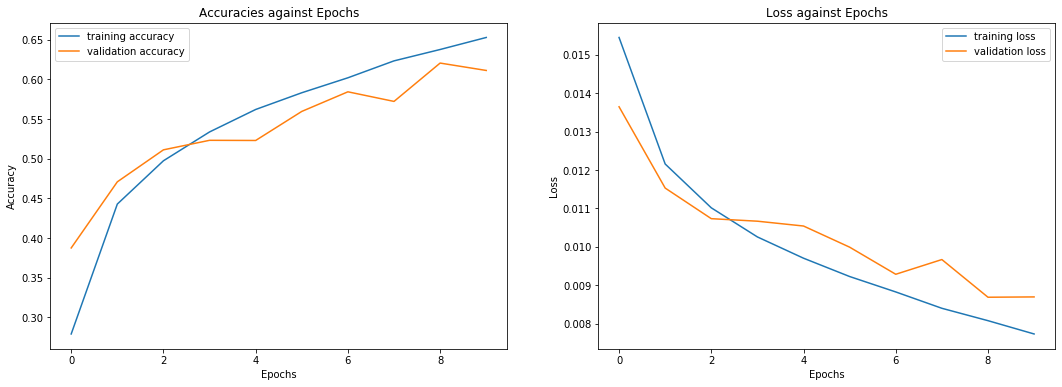

In [0]:
preprocess = transforms.Compose([
              transforms.ToTensor(), 
              transforms.Normalize((0.4914, 0.4822, 0.4465),
                                   (0.2023, 0.1994, 0.2010))
              ])
train_data = datasets.CIFAR10('./datalab', train=True, transform = preprocess)
val_data = datasets.CIFAR10('./datalab', train=False, transform = preprocess)
batch_size = 128
trainLoader = DataLoader(train_data, batch_size, shuffle=True, num_workers=0)
valLoader = DataLoader(val_data, batch_size, shuffle=False, num_workers=0)

train_acc1, val_acc1, train_loss1, val_loss1 = train_model(classifier, criterion,
                                                           optimizer, trainLoader, 
                                                           valLoader, len(train_data), 
                                                           len(val_data))
# print(len(train_acc1), len(val_acc1), len(train_loss1), len(val_loss1))
plot_result(train_acc1, val_acc1, train_loss1, val_loss1)

**Final Comments:** You should get a much better classification accuracy of this model. Try running it in some validation images and see how much better are the predictions of this model compared to the one used in a previous assignment.

#### **3. Use Resnet to make some predictions** (2pts)

Take pictures of two objects for which the ResNet network trained on ILSVRC works really well and show the predictions, do the same for two objects for which the network doesn't do well. Take your own pictures of objects at your place, don't download images from the internet.

In [0]:
# Your code goes here.
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
def apply(imag, m, cat, c = False, mp = None):
  if c == True:
    inputVar =  preprocessFn(imag).unsqueeze(0).cuda()
  else:
    inputVar =  preprocessFn(imag).unsqueeze(0)
  predictions = m(inputVar)
  probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
  if c == True:
    probs = (-probs).cpu().numpy()[0][:10] 
    indices = indices.cpu().numpy()[0][:10]
    for i in range(len(indices)): 
      indices[i] = mp[i]
  else:
    probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
  preds = [cat[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

  plt.title('\n'.join(preds))
  plt.imshow(imag); plt.grid('off'); plt.axis('off');

fn = '/content/gdrive/My Drive/'

A backpack predicted as backpack


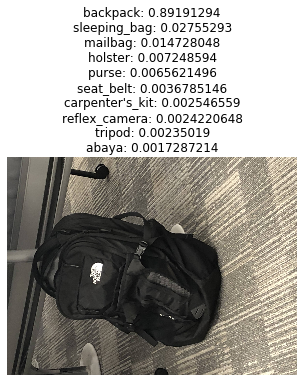

In [16]:
print('Correct: A backpack predicted as backpack')
w1 = Image.open(fn + 'backpack.jpg')
apply(w1, resnet, cat = imagenetClasses)

A pen predicted as ballpoint


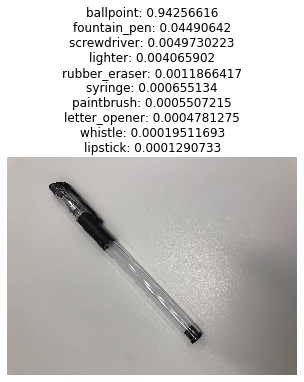

In [17]:
print('Correct: A pen predicted as ballpoint')
w2 = Image.open(fn + 'pen.jpg')
apply(w2, resnet, cat = imagenetClasses)

Wrong: A cup predicted as blog


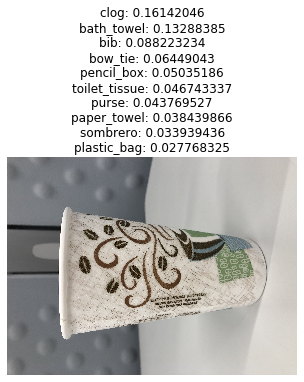

In [18]:
print('Wrong: A cup predicted as blog')
n1 = Image.open(fn + 'cup.jpg')
apply(n1, resnet, cat = imagenetClasses)

Wrong: A vault predicted as clog


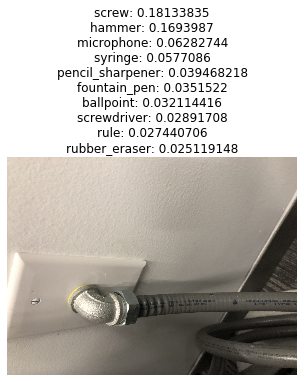

In [19]:
print('Wrong: A vault predicted as clog')
n2 = Image.open(fn + 'vault.jpg')
apply(n2, resnet, cat = imagenetClasses)

#### **4. Cats vs Dogs** (4pts)
In this section "finetune" a resnet Convolutional Neural Network (CNN) on the Dogs vs Cats Kaggle competition dataset https://www.kaggle.com/c/dogs-vs-cats. "Finetuning" means you will load a pre-trained model and replace the last layer with a new classification (linear + softmax or logistic layer), and then modify the weights of the current network for the new task using SGD training. This should lead to better results than training the same network from random weights.  The training data in this dataset has 25,000 images, I already separated the images into training: 20,000 images and validation: 5,000 images. You can download my training, validation splits from the following dropbox link: [cats_dogs.zip](https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip). You will have to write your own dataset class inheriting from torch.utils.data.Dataset, and a model that trains on this dataset. As usual, include plots making clear what is the accuracy that you achieved.

In [0]:
# upzip files and create dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision import models
import os
from torch.utils.data import DataLoader
import zipfile
from google.colab import drive 

drive.mount('/content/gdrive')
with zipfile.ZipFile('/content/gdrive/My Drive/cats_dogs_2.zip', 'r') as zipref: 
  zipref.extractall()

preprocess2 = transforms.Compose([
              transforms.RandomResizedCrop(224),
              transforms.ToTensor(), 
              transforms.Normalize((0.4914, 0.4822, 0.4465),
                                   (0.2023, 0.1994, 0.2010))
              ])
batch_size2 = 128
train_data2 = ImageFolder('cats_dogs_2/trainset', transform=preprocess2)
train_loader2 = DataLoader(train_data2, batch_size2, shuffle=True, num_workers=0)

val_data2 = ImageFolder('cats_dogs_2/valset', transform=preprocess2)
val_loader2 = DataLoader(val_data2, batch_size2, shuffle=True, num_workers=0)

print(train_data2.class_to_idx)
print(val_data2.class_to_idx)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


In [0]:
resnet50 = models.resnet50(pretrained = True);
resnet50.fc = nn.Linear(2048, 2, bias = True)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(resnet50.parameters(), learningRate)


Epoch 0: Training Accuracy: 0.9444 Training Loss: 0.0016



Epoch 0: Validation Acc: 0.9644 Validation Loss: 0.0006



Epoch 1: Training Accuracy: 0.9701 Training Loss: 0.0006



Epoch 1: Validation Acc: 0.9686 Validation Loss: 0.0006



Epoch 2: Training Accuracy: 0.9724 Training Loss: 0.0005



Epoch 2: Validation Acc: 0.9566 Validation Loss: 0.0008



Epoch 3: Training Accuracy: 0.9765 Training Loss: 0.0004



Epoch 3: Validation Acc: 0.9700 Validation Loss: 0.0006



Epoch 4: Training Accuracy: 0.9785 Training Loss: 0.0004



Epoch 4: Validation Acc: 0.9618 Validation Loss: 0.0007



Epoch 5: Training Accuracy: 0.9785 Training Loss: 0.0004



Epoch 5: Validation Acc: 0.9730 Validation Loss: 0.0007



Epoch 6: Training Accuracy: 0.9807 Training Loss: 0.0004



Epoch 6: Validation Acc: 0.9724 Validation Loss: 0.0005



Epoch 7: Training Accuracy: 0.9820 Training Loss: 0.0004



Epoch 7: Validation Acc: 0.9768 Validation Loss: 0.0005



Epoch 8: Training Accuracy: 0.9824 Training Loss: 0.0003



Epoch 8: Validation Acc: 0.9754 Validation Loss: 0.0005



Epoch 9: Training Accuracy: 0.9840 Training Loss: 0.0003



Epoch 9: Validation Acc: 0.9742 Validation Loss: 0.0006


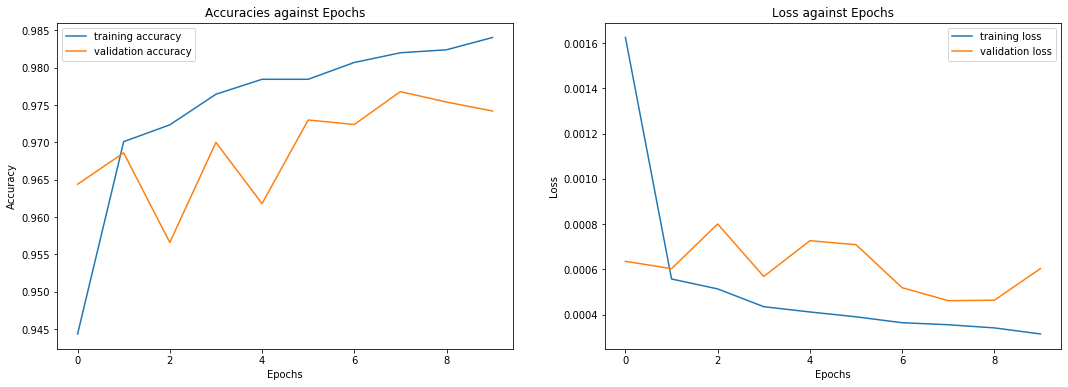

In [0]:
train_acc2, val_acc2, train_loss2, val_loss2 = train_model(resnet50, criterion2,
                                                           optimizer2, train_loader2,
                                                           val_loader2, len(train_data2),
                                                           len(val_data2), Flag=True)
plot_result(train_acc2, val_acc2, train_loss2, val_loss2)

#### **5. Fine-tuning ResNet to the COCO-Dataset 80-category dataset**
Grading: 7pts - Optional for extra credit - but no partial credit on this question)

The COCO (Common Objects in Context) Dataset has 80 object categories. You can browse it here http://cocodataset.org/#home. This dataset also has bounding box annotations but we will not use them in this project. You will only map each image to an 80-dimensional vector where each entry corresponds to an object type, where the value is 1 if the object-type is present and 0 otherwise. (i.e. will not use box annotations, nor use the number of objects of each type). **Hints:** (1) To build the dataloader for COCO you can reuse the dataloder in pytorch for COCO but you need to modify it to return an 80-dimensional vector as label http://pytorch.org/docs/master/torchvision/datasets.html#coco (2) The 80-category prediction will require a different loss since these labels are not mutually exclusive, you will have to use torch.nn.BCEWithLogitsLoss. **Note:** For speed and in order to reduce network overhead use only 20,000 images for training, and 1,000 images for validation.

Show three example results of your trained model on the validation set of the COCO dataset. More especifically show the top ten predicted categories along with the score for each for three sample images.

In [21]:
# Install Coco API
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../..
%cd /content/

Cloning into 'cocoapi'...
remote: Enumerating objects: 959, done.
remote: Total 959 (delta 0), reused 0 (delta 0), pack-reused 959
Receiving objects: 100% (959/959), 11.69 MiB | 12.95 MiB/s, done.
Resolving deltas: 100% (570/570), done.
/content/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/

In [2]:
from google.colab import drive
import zipfile
import os
drive.mount('/content/gdrive')
with zipfile.ZipFile('/content/gdrive/My Drive/coco_reduced.zip', 'r') as zipref: 
  zipref.extractall()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [25]:
import json
from PIL import Image
import os

reindex = {}
index = {}
# 80 possible labels
all_labels = []
all_labels.extend(range(1, 12)); all_labels.extend(range(13, 26))
all_labels.extend([27, 28]); all_labels.extend(range(31, 45))
all_labels.extend(range(46, 66)); all_labels.extend([67, 70])
all_labels.extend(range(72, 83)); all_labels.extend(range(84, 91))
print(len(all_labels))
# Map each label into value in 0..80
for i in range(80): 
  reindex[all_labels[i]] = i
for i in range(80): 
  index[i] = all_labels[i]

def one_hot(arr): 
  oh = np.zeros(80)
  for a in arr: 
    oh[reindex[a]] = 1
  return torch.tensor(oh)

train_img, train_idx = [], []
val_img, val_idx = [], []
with open('coco_reduced/train_20000cat.json', 'r') as ct: 
  dict_train = json.loads(ct.read())
  dict_train = json.loads(dict_train)
with open('coco_reduced/val_1000cat.json', 'r') as vt: 
  dict_val = json.loads(vt.read())
  dict_val = json.loads(dict_val)
for filename in tqdm(os.listdir('coco_reduced/train_img')):
  train_img.append(Image.open('coco_reduced/train_img/' + filename).copy())
  train_idx.append(one_hot(dict_train[str(int(filename[:-4]))]))
for filename in tqdm(os.listdir('coco_reduced/val_img')):
  val_img.append(Image.open('coco_reduced/val_img/' + filename).copy())
  val_idx.append(one_hot(dict_val[str(int(filename[:-4]))]))

80


In [0]:
from pycocotools.coco import COCO
from torch.utils.data import Dataset

class DatasetCOCO(Dataset):
  def __init__(self, imgs, labels, preprocess=None): 
    self.imags = imgs
    self.labels = labels
    self.preprocess = preprocess
  def __getitem__(self, idx):
    imag = self.imags[idx]
    if imag.mode == 'L': 
      imag = imag.convert('RGB')
    if self.preprocess:
      return [self.preprocess(imag), self.labels[idx]]
    else: 
      return [imag, self.labels[idx]]
  def __len__(self): 
    return len(self.imags)

preprocess_coco = transforms.Compose([
              transforms.RandomResizedCrop(224),
              transforms.ToTensor(),
              transforms.Normalize((0.4914, 0.4822, 0.4465),
                                   (0.2023, 0.1994, 0.2010))
              ])

In [0]:
torch.cuda.empty_cache()

In [28]:
coco_batch_size = 128
train_coco_set = DatasetCOCO(train_img, train_idx, preprocess_coco)
val_coco_set = DatasetCOCO(val_img, val_idx, preprocess_coco)
train_coco_loader = DataLoader(train_coco_set, coco_batch_size, shuffle=True, num_workers=0)
val_coco_loader = DataLoader(val_coco_set, coco_batch_size, shuffle=True, num_workers=0)
coco_resnet18 = models.resnet18(pretrained = True)
coco_resnet18.fc = nn.Linear(512, 80)
learningRate = 0.05
loss_coco = nn.BCEWithLogitsLoss()
optimizer_coco = optim.SGD(coco_resnet18.parameters(), learningRate)
coco_train_acc, coco_val_acc, coco_train_loss, coco_val_loss = train_model(coco_resnet18, loss_coco,
                                                           optimizer_coco, train_coco_loader, 
                                                           val_coco_loader, len(train_coco_set), 
                                                           len(val_coco_set), Flag = False)
# plot_result(coco_train_acc, coco_val_acc, coco_train_loss, coco_val_loss)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.4MB/s]



Epoch 0: Training Loss: 0.0015



Epoch 0: Validation Loss: 0.0011



Epoch 1: Training Loss: 0.0010



Epoch 1: Validation Loss: 0.0010



Epoch 2: Training Loss: 0.0010



Epoch 2: Validation Loss: 0.0010



Epoch 3: Training Loss: 0.0009



Epoch 3: Validation Loss: 0.0009



Epoch 4: Training Loss: 0.0009



Epoch 4: Validation Loss: 0.0009



Epoch 5: Training Loss: 0.0008



Epoch 5: Validation Loss: 0.0009



Epoch 6: Training Loss: 0.0008



Epoch 6: Validation Loss: 0.0008



Epoch 7: Training Loss: 0.0008



Epoch 7: Validation Loss: 0.0008



Epoch 8: Training Loss: 0.0008



Epoch 8: Validation Loss: 0.0008



Epoch 9: Training Loss: 0.0008



Epoch 9: Validation Loss: 0.0008


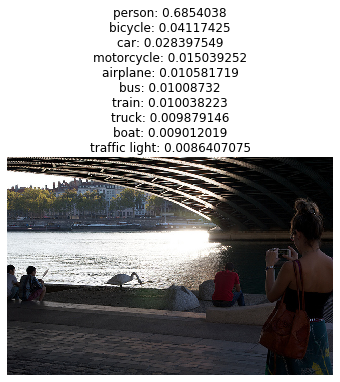

In [32]:
import json
coco_resnet18.eval()
coco_classes = {entry["id"]: entry["name"] for entry in 
                   json.load(open('/content/gdrive/My Drive/coco_cat.json'))}
coco_val_1 = Image.open('coco_reduced/val_img/000000001268.jpg')
apply(coco_val_1, coco_resnet18, coco_classes, True, index)

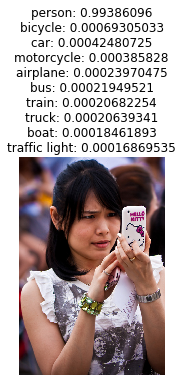

In [33]:
coco_val_2 = Image.open('coco_reduced/val_img/000000001296.jpg')
apply(coco_val_2, coco_resnet18, coco_classes, True, index)

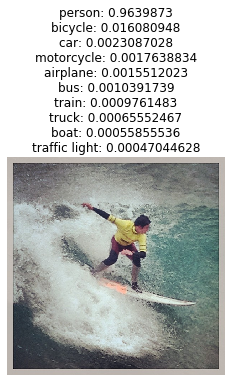

In [39]:
coco_val_3 = Image.open('coco_reduced/val_img/000000004765.jpg')
apply(coco_val_3, coco_resnet18, coco_classes, True, index)

**Final Comments:** In this section you learned to use a very deep neural network that was trained to recognize 1000 categories, then you finetuned this network to another dataset that only had 80 categories, and for a different criterion (loss function). How would you measure the accuracy of this model?

Since there are multiple labels associated with each picture, we can calculate how many predicted labels are within the groud-truth labels to calculate the accuracy of predictions. 